In [16]:
import pandas as pd
from bs4 import BeautifulSoup
import time
import numpy as np

import nltk
from nltk.stem.porter import *
import string
from nltk.tokenize import TweetTokenizer
token = TweetTokenizer()
stemmer = PorterStemmer() 
from nltk.corpus import stopwords # Import the stop word list

## Load the datasets

In [1]:
# Take one of the books, with approx uniform distribution for its ratings
data = pd.read_csv('Paula_Hawkins-The-Girl-On-The-Train.csv', sep = '\t', header = None)

# Rename columns
data.columns = ['rating', 'tail', 'title', 'review']

NameError: name 'pd' is not defined

In [7]:
data.head()

,rating,tail,title,review
0,5.0,/gp/customer-reviews/R2QL7LO8IQZ7V2?ASIN=15946...,Best Hitchcock style mystery of voyeuristic ob...,"<span class=""a-size-base review-text"">Rachel i..."
1,2.0,/gp/customer-reviews/R1UP4LQV7KT04M?ASIN=15946...,ALCOHOLIC AMNESIA,"<span class=""a-size-base review-text"">THE GIRL..."
2,5.0,/gp/customer-reviews/R2UWX7IZYY45DQ?ASIN=15946...,The Gillian Flynn comparisons are utterly accu...,"<span class=""a-size-base review-text"">This was..."
3,4.0,/gp/customer-reviews/R376RH2ZC94RRY?ASIN=15946...,This is a Must Read.,"<span class=""a-size-base review-text"">Edgy, he..."
4,2.0,/gp/customer-reviews/R4R7KVVCO9YT5?ASIN=159463...,It gets thin and annoying by the end,"<span class=""a-size-base review-text"">After re..."


In [8]:
print('There are ', data.shape[0], ' reviews in this dataset')

There are  37139  reviews in this dataset


In [9]:
# Check the first review
data.review[0]

'<span class="a-size-base review-text">Rachel is a woman who considers herself worthless. She feels that women are only valued for two things: their looks and their role as a mother.  She is barren and rather plain looking.  Unbeknownst to her landlady she has lost her job but continues to ride the commuter train twice a day.  Unfortunately she must pass the home of her ex-husband Tom and his new wife Anna.  They\'ve recently had a child which is something Rachel was unable to produce when she was married to him.  He\'s moved his new family into the home that he and Rachel once shared. Tom posted a picture of himself and his newborn on Facebook with the caption that he\'s never been happier.<br/><br/>Rachel, in her despondency, has taken to drinking to a point where she has blackouts and forgets that she drunk calls her husband many times a night, even shows up at his home.  Because of a signal malfunction she often finds her rail car stopped on the tracks next to her former home.  She

Some cleaning need to be done on reviews!

In [10]:
def process(x):
    '''
    Function to convert the html review into clean text, then remove non-letters character, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''

    # 1. Remove HTML
    review = BeautifulSoup(x, "html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters = re.sub("[^a-zA-Z]", " ", review) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [12]:
data['processed'] = data['review'].apply(lambda x: process(x))

# Bag of words

Create features corresponding to each word's frequency. Keep only the $5000$ most frequent words.

In [13]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(data['processed'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Creating the bag of words...



In [17]:
# Examine the size and the sparsity of the tfidf_matrix
size = train_data_features.shape
sparsity = np.count_nonzero(train_data_features) / train_data_features.size

print('The matrix is of shape '+str(size)+' and its sparsity is '+str(sparsity))

The matrix is of shape (37139, 5000) and its sparsity is 0.002618923503594604


In [18]:
print(train_data_features.shape)

(37139, 5000)


In [19]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['aa', 'abandon', 'abdic', 'ability', 'able', 'abound', 'abrupt', 'abruptly', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absurd', 'abuse', 'abused', 'abusers', 'abusive', 'accents', 'accept', 'acceptable', 'accessible', 'accident', 'acclaim', 'acclaimed', 'accolades', 'accomplished', 'account', 'accounts', 'accurate', 'accurately', 'achieve', 'achieved', 'acquainted', 'acquired', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'actively', 'activities', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'adaptation', 'adapted', 'add', 'added', 'addict', 'addicted', 'addicting', 'addiction', 'addictions', 'addictive', 'addicts', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'adds', 'adept', 'adjectives', 'adjust', 'admirable', 'admiration', 'admire', 'admired', 'admit', 'admitted', 'admittedly', 'adore', 'adult', 'adulterer', 'adultery', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'a

In [20]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

15 aa
6 abandon
6 abdic
34 ability
474 able
12 abound
10 abrupt
8 abruptly
6 absent
29 absolute
272 absolutely
5 absorb
62 absorbed
63 absorbing
11 absurd
84 abuse
25 abused
9 abusers
40 abusive
9 accents
28 accept
10 acceptable
5 accessible
14 accident
6 acclaim
6 acclaimed
5 accolades
14 accomplished
24 account
39 accounts
42 accurate
11 accurately
13 achieve
6 achieved
6 acquainted
6 acquired
63 across
43 act
12 acted
11 acting
165 action
127 actions
14 active
10 actively
10 activities
21 actors
7 actress
6 actresses
17 acts
52 actual
447 actually
7 adaptation
8 adapted
92 add
57 added
16 addict
19 addicted
37 addicting
116 addiction
14 addictions
50 addictive
6 addicts
26 adding
25 addition
7 additional
5 additionally
7 address
6 addressed
44 adds
5 adept
5 adjectives
8 adjust
21 admirable
5 admiration
22 admire
5 admired
114 admit
5 admitted
15 admittedly
12 adore
24 adult
9 adulterer
28 adultery
13 adults
13 advance
8 advanced
14 advantage
17 adventure
16 advertised
21 advice
10 

### Algorithms

In [22]:
labels = data['rating']

In [25]:
from sklearn.cross_validation import train_test_split

# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, labels, test_size=0.3, random_state=42)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

start = time.time()

# Initialize the model
clf = LogisticRegression(C = 0.001)

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print(time.time() - start)

2.2929325103759766


In [27]:
np.sum(labels_predicted == labels_test) / len(labels_test)

0.45135523245377851

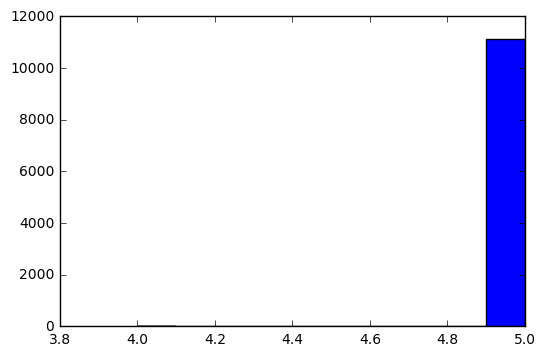

In [29]:
plt.hist(labels_predicted, color = 'b')
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

start = time.time()

# Initialize the model
clf = RandomForestClassifier(n_estimators = 100)

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print(time.time() - start)

335.8414611816406


In [31]:
np.sum(labels_predicted == labels_test) / len(labels_test)

0.42353257942918687

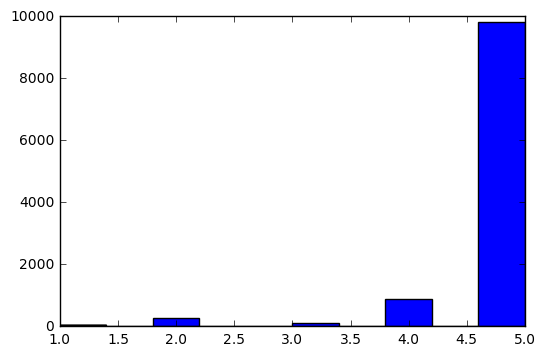

In [32]:
plt.hist(labels_predicted, color = 'b')
plt.show()

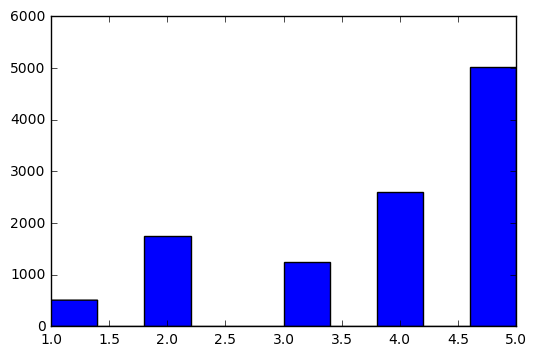

In [35]:
plt.hist(labels_test, color = 'b')
plt.show()

In [33]:
np.sum(np.abs(labels_predicted - labels_test) <= 2) / len(labels_test)

0.80488242685334765

#### Try with a binary sentiment label

In [43]:
def sentiment(x):
    
    if x < 4:
        res = 0
    else:
        res = 1
        
    return res

In [44]:
data['sentiment'] = data['rating'].apply(lambda x: sentiment(x))

In [45]:
labels = data['sentiment']

# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

In [46]:
start = time.time()

# Initialize the model
clf = LogisticRegression(C = 0.001)

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print(time.time() - start)

1.3055164813995361


In [47]:
np.sum(labels_predicted == labels_test) / len(labels_test)

0.6849757673667205

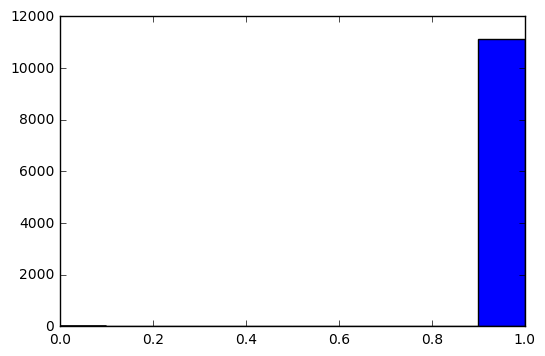

In [48]:
plt.hist(labels_predicted, color = 'b')
plt.show()

In [49]:
start = time.time()

# Initialize the model
clf = RandomForestClassifier(n_estimators = 100)

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print(time.time() - start)

348.1887125968933


In [50]:
np.sum(labels_predicted == labels_test) / len(labels_test)

0.66675641716029443

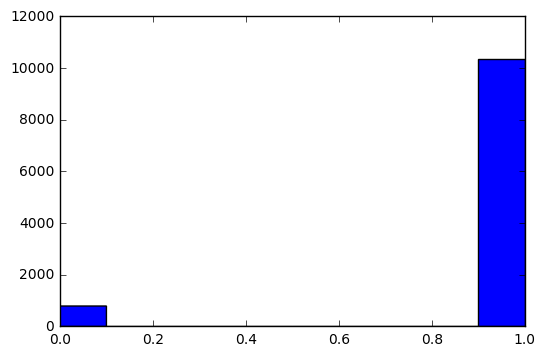

In [51]:
plt.hist(labels_predicted, color = 'b')
plt.show()

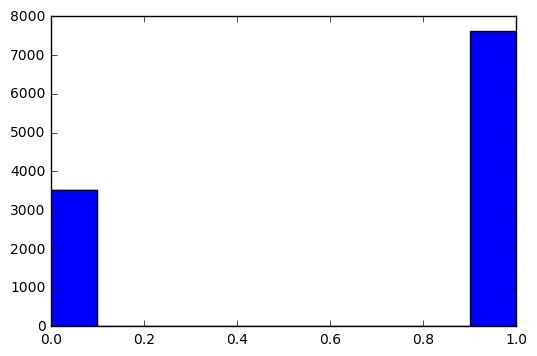

In [52]:
plt.hist(labels_test, color = 'b')
plt.show()